In [ ]:
#Imports
import tensorflow as tf
import tensorflow_hub as hub
from sklearn import preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import numpy as np
import re
from tqdm import tqdm
import pickle
from sklearn.metrics import confusion_matrix,f1_score,classification_report
import matplotlib.pyplot as plt
import itertools
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
import tensorflow.keras.backend as K
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score

In [ ]:
!pip install fasttext 

In [ ]:
import fasttext

In [ ]:
df_train = pd.read_csv('./Hinglish/training_data_semeval.csv')
df_test = pd.read_csv('./Hinglish/testing_data_semeval.csv')

train = list(df_train['X'].values)
test = list(df_test['X'].values)

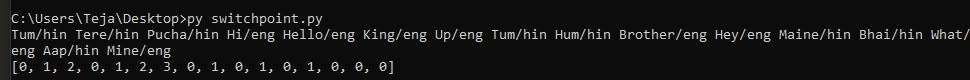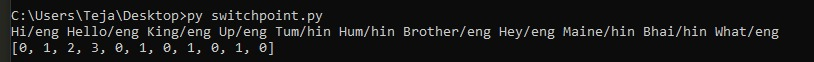

In [ ]:
# Function to get Switching code. Above is an image showing how this function works for a given tweet

def getIndex(data):
  final_index = []
  for sentence in data:
    index = 0
    index_list = []
    word_list = (sentence.split())
    if len(word_list)==1:
        index_list.append(0)
    else:
        for i in range((len(word_list) - 1)):
            if i == 0:
                index_list.append(index)
            if word_list[i][-1] == word_list[i+1][-1]:
                index = index + 1
                index_list.append(index)
            else:
                index = 0
                index_list.append(index)
    final_index.append(index_list)
  return final_index


In [ ]:
# def getIndex(data):
#   final_index = []
#   for sentence in data:
#     index = 0
#     index_list = []
#     word_list = (sentence.split())
#     if len(word_list)==1:
#         index_list.append(0)
#     else:
#       for i in range((len(word_list) - 1)):
#         if i == 0:
#           index_list.append(index)
#         if word_list[i][-1] == word_list[i+1][-1]:
#           index = index + 1
#           index_list.append(index)
#         else:
#           if word_list[i][-1] == 'g':
#             index = index + 1
#             index_list.append(index)
#           else:
#             index = 0
#             index_list.append(index)
#     final_index.append(index_list)
#   return final_index

In [ ]:
# Loading Preprocessed data and tags

train_labels = pd.read_csv('./Hinglish/training_data_semeval_tags.csv')
test_labels = pd.read_csv('./Hinglish/testing_data_semeval_tags.csv')

# getIndex generates the switching code for a given tweet with its tag
train_index = getIndex(train_labels['X'].values)
test_index = getIndex(test_labels['Tags'].values)

In [ ]:
#Adding CLS and SEP tokens to each tweet

def cls_sep(data):
  final_tokens = []
  for twwt in data:
    l = 'CLS ' + twwt + ' SEP' 
    final_tokens.append(l)
  return final_tokens

train = cls_sep(train)
test = cls_sep(test)

In [ ]:
#Vocabulary of 8000 words
#max len of a input is 30 tokens 
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=8000,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(train)
train_sequences = tokenizer.texts_to_sequences(train)
test_sequences = tokenizer.texts_to_sequences(test)

X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=30, padding='pre', truncating='pre')
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=30, padding='pre', truncating='pre')

# For each token we have a switching code, if actual input len is less than 30, we are padding with value=29
X_train_index = tf.keras.preprocessing.sequence.pad_sequences(train_index, maxlen=30, padding='pre', truncating='pre', value=29)
X_test_index = tf.keras.preprocessing.sequence.pad_sequences(test_index, maxlen=30, padding='pre', truncating='pre', value=29)
X_train_index[0]

array([29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,  0,  0,  1,  0,  1,
        2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [ ]:
# Masking 
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_masks(inp):
  enc_padding_mask = create_padding_mask(inp)
  return enc_padding_mask

In [ ]:
train_mask = create_masks(X_train)
test_mask = create_masks(X_test)

In [ ]:
def encode(le, labels):
  enc = le.transform(labels)
  return tf.keras.utils.to_categorical(enc)

def decode(one_hot):
  dec = np.argmax(one_hot, axis=1)
  return dec

In [ ]:
# Preparing the target values

y = list(df_train['y'].values)
yy = list(df_test['y'].values)

le = preprocessing.LabelEncoder()
le.fit(y)
print(le.classes_)

y_train_b = encode(le, y)
y_test_b = encode(le, yy)

y_train = le.transform(y)
y_test = le.transform(yy)


In [ ]:
# Loading the Fasttext model, which is trained on 100k hinglish datapoints from twitter.
e_model = fasttext.load_model("H-model_ft")
word_index = tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in word_index.items():
    try:    
      embedding_vector = e_model[word]
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
    except:
      embedding_matrix[i] = np.zeros((300,))
      print(1)

In [ ]:
tf.config.run_functions_eagerly(True)
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads  # 12 heads in our case
    self.d_model = d_model  # d_model is 300 
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads #depth is 300/12 = 25
    
    # query, key and value matrices
    self.wq = tf.keras.layers.Dense(d_model, activation='relu')
    self.wk = tf.keras.layers.Dense(d_model, activation='relu')
    self.wv = tf.keras.layers.Dense(d_model, activation='relu')
    
    self.dense = tf.keras.layers.Dense(d_model, activation='relu')
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def _generate_relative_positions_matrix(self, length, max_relative_position,
                                        cache=False):
    """Generates matrix of relative positions between inputs."""
    if not cache:
      range_vec = tf.range(length)
      range_mat = tf.reshape(tf.tile(range_vec, [length]), [length, length])
      distance_mat = range_mat - tf.transpose(range_mat)
    else:
      distance_mat = tf.expand_dims(tf.range(-length+1, 1, 1), 0)
    distance_mat_clipped = tf.clip_by_value(distance_mat, -max_relative_position,
                                            max_relative_position)
    # Shift values to be >= 0. Each integer still uniquely identifies a relative
    # position difference.
    final_mat = distance_mat_clipped + max_relative_position
    return final_mat

  def _generate_relative_positions_embeddings(self, length, depth,
                                              max_relative_position, name,
                                              cache=False):
    """Generates tensor of size [1 if cache else length, length, depth]."""
    with tf.compat.v1.variable_scope(name):
      relative_positions_matrix = self._generate_relative_positions_matrix(
          length, max_relative_position, cache=cache)
      vocab_size = max_relative_position * 2 + 1
      # Generates embedding for each relative position of dimension depth.
      embeddings_table = tf.compat.v1.get_variable(name, [vocab_size, depth])
      embeddings = tf.gather(embeddings_table, relative_positions_matrix)
      return embeddings

  def _relative_attention_inner(self, x, y, z, transpose):
    
    batch_size = tf.shape(x)[0]
    heads = 12 
    length = 30

    # xy_matmul is [batch_size, heads, length or 1, length or depth]
    xy_matmul = tf.matmul(x, y, transpose_b=transpose)
    # x_t is [length or 1, batch_size, heads, length or depth]
    x_t = tf.transpose(x, [2, 0, 1, 3])
    # x_t_r is [length or 1, batch_size * heads, length or depth]
    x_t_r = tf.reshape(x_t, [length, heads * batch_size, -1])
    # x_tz_matmul is [length or 1, batch_size * heads, length or depth]
    x_tz_matmul = tf.matmul(x_t_r, z, transpose_b=transpose)
    # x_tz_matmul_r is [length or 1, batch_size, heads, length or depth]
    x_tz_matmul_r = tf.reshape(x_tz_matmul, [length, batch_size, heads, -1])
    # x_tz_matmul_r_t is [batch_size, heads, length or 1, length or depth]
    x_tz_matmul_r_t = tf.transpose(x_tz_matmul_r, [1, 2, 0, 3])
    return tf.math.add(xy_matmul, x_tz_matmul_r_t)

  def dot_product_attention_relative(self, q,
                                   k,
                                   v,
                                   bias,
                                   max_relative_position,
                                   dropout_rate=0.0,
                                   image_shapes=None,
                                   save_weights_to=None,
                                   name=None,
                                   make_image_summary=True,
                                   cache=False):
    if not max_relative_position:
      raise ValueError("Max relative position (%s) should be > 0 when using "
                      "relative self attention." % (max_relative_position))
    with tf.compat.v1.variable_scope(
        name, default_name="dot_product_attention_relative",
        values=[q, k, v]) as scope:

      # This calculation only works for self attention.
      # q, k and v must therefore have the same shape.
      if not cache:
        q.get_shape().assert_is_compatible_with(k.get_shape())
        q.get_shape().assert_is_compatible_with(v.get_shape())

      # Use separate embeddings suitable for keys and values.
      depth = 25  #300/12
      length = 30

      #get Aij(k) and Aij(v), relative position of keys and values
      relations_keys = self._generate_relative_positions_embeddings(length, depth, max_relative_position, "relative_positions_keys",cache=cache)
      relations_values = self._generate_relative_positions_embeddings(length, depth, max_relative_position, "relative_positions_values",cache=cache)

      # Compute self attention considering the relative position embeddings(important*).
      logits = self._relative_attention_inner(q, k, relations_keys, True)
      weights = tf.nn.softmax(logits)

      return self._relative_attention_inner(weights, v, relations_values, False), weights
 
  def call(self, v, k, q, mask):

    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
  
    oot, attweight = self.dot_product_attention_relative(q, k, v, bias=None, max_relative_position=20, dropout_rate=0.1, image_shapes=None, 
                                                         save_weights_to=None, name=None,make_image_summary=False, cache=False)
    scaled_attention = tf.transpose(oot, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(oot, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
    output = tf.reshape(output, (batch_size, 30, 300))

    return output, attweight

In [ ]:
def point_wise_feed_forward_network(d_model, dff): 
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model, activation='relu')  # (batch_size, seq_len, d_model)
  ])

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
    self.posembedding = tf.keras.layers.Embedding(30, d_model, trainable=True)
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask, index):
    # positions = tf.range(start=0, limit=30, delta=1) #uncomment this and pass in to posembedding for only dynamic pos 
    positions = self.posembedding(index)
    x += positions
    attn_output, att_weights= self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model) # with Attention
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model) #with Attention
    
    return out2, att_weights

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model, weights=[embedding_matrix], trainable=False)
    # self.pos_encoding = positional_encoding(maximum_position_encoding, 
    #                                         self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask, index):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, input_seq_len, d_model), #Getting word embedding for each token using fasttext.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    # x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x, wt = self.enc_layers[i](x, training, mask, index)
      attention_weights[f'encoder_layer{i+1}'] = wt

    if training==False:
      return x, attention_weights
      
    return x  # (batch_size, input_seq_len, d_model)

In [ ]:
# Getting Tf-Idf weight avg fasttext embedding.

fasttext_words = set(e_model.words)

vectorizer_tfidf = TfidfVectorizer(max_features=8000)
vocab = vectorizer_tfidf.fit(train)

tf_train = vectorizer_tfidf.transform(train)
tf_test = vectorizer_tfidf.transform(test)

dictionary = dict(zip(vectorizer_tfidf.get_feature_names(), list(vectorizer_tfidf.idf_)))
tfidf_words = set(vectorizer_tfidf.get_feature_names())

tfidf_train = []
for sentence in train:
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if (word in fasttext_words) and (word in tfidf_words):
      vec = e_model[word]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf) 
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  tfidf_train.append(vector)


tfidf_test = []
for sentence in test:
  vector = np.zeros(300)
  tf_idf_weight = 0
  for word in sentence.split():
    if (word in fasttext_words) and (word in tfidf_words):
      vec = e_model[word]
      tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
      vector += (vec * tf_idf) 
      tf_idf_weight += tf_idf
  if tf_idf_weight != 0:
    vector /= tf_idf_weight
  tfidf_test.append(vector)

In [ ]:
MAX_SEQUENCE_LENGTH = 30

In [ ]:
tf.keras.backend.clear_session()
inputs = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Tokens')
masks = tf.keras.layers.Input(shape=(1,1,MAX_SEQUENCE_LENGTH), name='Mask')
inputs_index = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), name='Index')
encoder = Encoder(num_layers=2, d_model=300, num_heads=12,
                         dff=2048, input_vocab_size=len(word_index) + 1,
                         maximum_position_encoding=10000)
x = encoder(inputs, training=True, mask=masks, index=inputs_index)
x = tf.keras.layers.BatchNormalization()(x)
x1 = tf.keras.layers.Conv1D( 128, 3, strides=1, padding='valid', activation='relu', name='Conv_ID-1')(x)
x1 = tf.keras.layers.BatchNormalization()(x1)
x2 = tf.keras.layers.Conv1D( 128, 3, strides=1, padding='valid', activation='relu', name='Conv_ID-2')(x)
x2 = tf.keras.layers.BatchNormalization()(x2)
concat = tf.keras.layers.Concatenate()([x1, x2])
x = tf.keras.layers.GlobalAveragePooling1D()(concat)
inputs_tfidf = tf.keras.layers.Input(shape=(300,), name='tf-idf(fasttext)')
x3 = tf.keras.layers.Dense(256,activation='relu', name='FC-1')(inputs_tfidf)
x3 = tf.keras.layers.BatchNormalization()(x3)
x = tf.keras.layers.Concatenate()([x3, x])
x = tf.keras.layers.Dense(128,activation='relu', name='FC-2')(x)
x = tf.keras.layers.BatchNormalization()(x)
dense = tf.keras.layers.Dense(64,activation='relu', name='FC-3')(x)
x = tf.keras.layers.BatchNormalization()(x)
drop = tf.keras.layers.Dropout(0.1)(dense)
pred = tf.keras.layers.Dense(3, activation='softmax', name='Softmax')(drop)
model = tf.keras.Model(inputs=[inputs,masks,inputs_index,inputs_tfidf], outputs=pred)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Tokens (InputLayer)             [(None, 30)]         0                                            
__________________________________________________________________________________________________
Index (InputLayer)              [(None, 30)]         0                                            
__________________________________________________________________________________________________
Mask (InputLayer)               [(None, 1, 1, 30)]   0                                            
__________________________________________________________________________________________________
encoder (Encoder)               (None, 30, 300)      17859848    Tokens[0][0]                     
                                                                 Index[0][0]                  

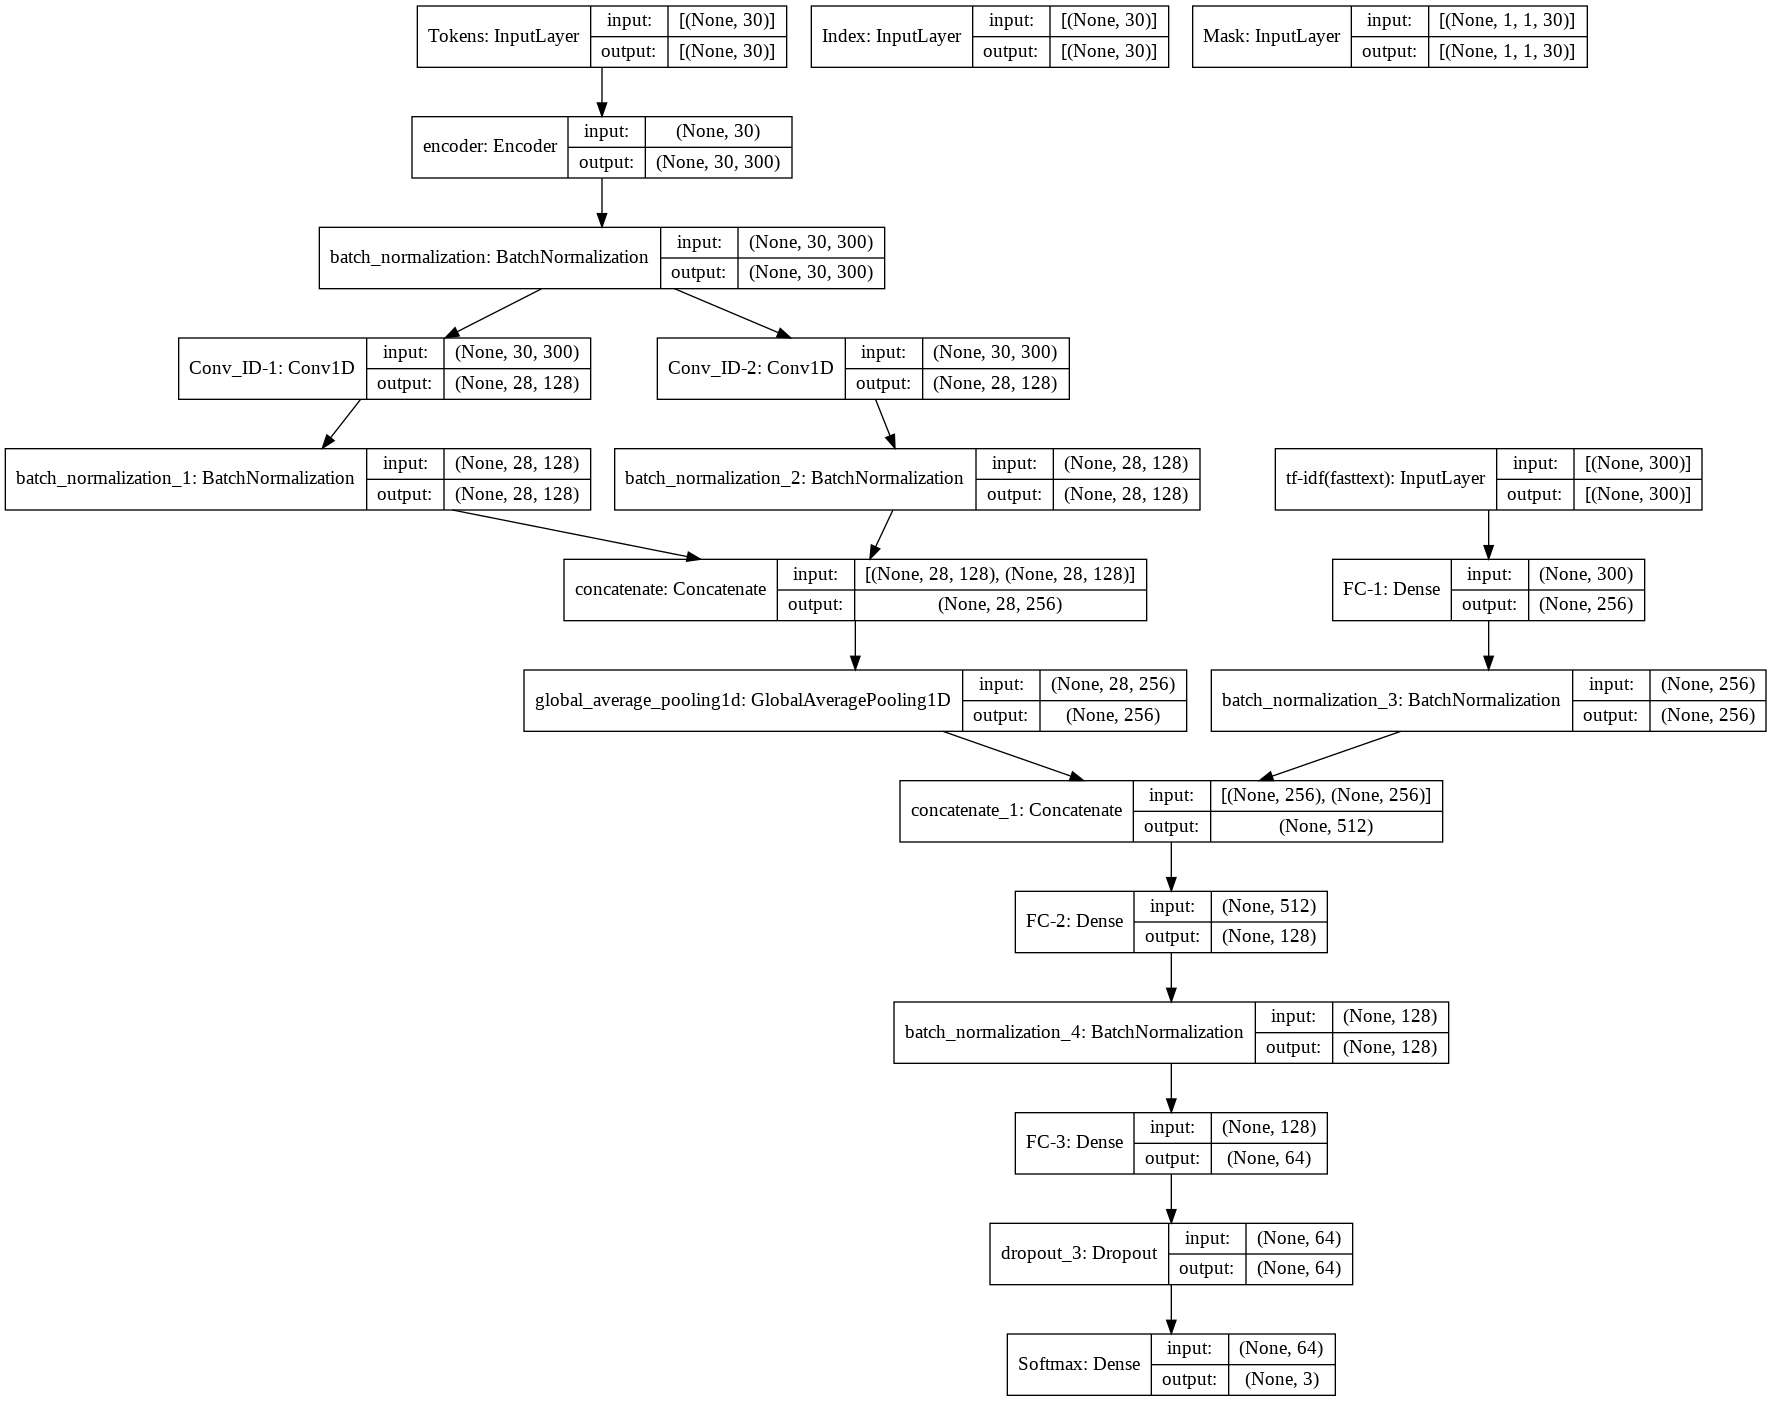

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:

class History(tf.keras.callbacks.Callback):
    
  def __init__(self, X_test, test_mask, y_test, X_train, train_mask, y_train, tfidf_train, tfidf_test, X_train_index, X_test_index):
    super().__init__()
    # self.validation_data = validation_data

  def on_train_begin(self, logs={}):
    self.history={'micro_f1': [], 'auc': []}
    return
      
  def on_epoch_end(self, epoch, logs={}):

    y_pred = self.model.predict([X_test, test_mask, X_test_index, tfidf_test])
    y_pred = np.argmax(y_pred, axis=1)
    f1_val = f1_score(y_test, y_pred, average='weighted')

    y_pred = self.model.predict([X_train, train_mask, X_train_index, tfidf_train])
    y_pred = np.argmax(y_pred, axis=1)
    f1_train = f1_score(y_train, y_pred, average='weighted')
    print('f1-train score:--{} ====== f1-val score:--{}'.format(f1_train,f1_val))

    return 

In [ ]:
tfidf_train = np.array(tfidf_train)
tfidf_test = np.array(tfidf_test)

In [ ]:

# Training.
history = History(X_test, test_mask, y_test, X_train, train_mask, y_train, tfidf_train, tfidf_test, X_train_index, X_test_index)
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

#Using callbacks such as LearningRateScheduler and ReduceLROnPlateau to control overfitting 

opt = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)
learningRate_Schedular = tf.keras.callbacks.LearningRateScheduler(scheduler)
learningRate_metric = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=0)
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
history=model.fit([X_train, train_mask, X_train_index, tfidf_train], y_train_b, batch_size=200, epochs=50, 
                  validation_data=([X_test, test_mask, X_test_index, tfidf_test], y_test_b), 
                  callbacks=[history, learningRate_Schedular, learningRate_metric])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/50
85/85 [==============================] - 23s 262ms/step - loss: 0.9433 - val_loss: 0.9806
f1-train score:--0.42155468616361996 ====== f1-val score:--0.43206586688116266
Epoch 2/50
85/85 [==============================] - 22s 255ms/step - loss: 0.7619 - val_loss: 0.8746
f1-train score:--0.5703820698667512 ====== f1-val score:--0.570490212783078
Epoch 3/50
85/85 [==============================] - 24s 278ms/step - loss: 0.6763 - val_loss: 0.7923
f1-train score:--0.657816328965994 ====== f1-val score:--0.6406542989155894
Epoch 4/50
85/85 [==============================] - 24s 288ms/step - loss: 0.5961 - val_loss: 0.7291
f1-train score:--0.7164772927840548 ====== f1-val score:--0.6758045614569924
Epoch 5/50
85/85 [==============================] - 38s 452ms/step - loss: 0.5152 - val_loss: 0.8481
f1-train score:--0.664534836271819 ====== f1-val score:--0.6011310452524121
Epoch 6/50
85/85 [==============================] - 26s 310ms/step - loss: 0.4379 - val_loss: 0.7019
f1-train s

KeyboardInterrupt: ignored

In [ ]:
y_test_pred = model.predict([X_test, test_mask, X_test_index, tfidf_test])
y_test_pred = np.argmax(y_test_pred, axis=1)
print(f1_score(y_test, y_test_pred, average='weighted'))
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


0.75639097598672
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       900
           1       0.70      0.72      0.71      1100
           2       0.79      0.79      0.79      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



In [ ]:
#Intrinsic evaluation 
#elmo --> 55
#lstm --> 56
#3 headed Attention Based --> 65
#Dynamic pos embedding based 3 headed attention --> 68.7
#code switching(1) based 3 headed attention --> 69.79
#code switching(1) based with 12 headed attention and tuning --> 73.52
#Relative pos encoding with 12 headed attention --> 73.4
#Relative and code switching based 12 headed attention --> 75.56 (semeval data)
#Relative and code switching based 12 headed attention --> 68.14(on iiith data)
#Relative + index positioning with 12 headed attention --> 73
#Relative left to right and right to left + switching --> 74

In [ ]:
# switching point(1) --> (0 at every switch)
# switching point(2) --> (if L1(hin)-->L2(eng)=0)

#https://arxiv.org/pdf/2006.15595.pdf
#https://arxiv.org/pdf/1803.02155.pdf
#https://arxiv.org/pdf/2105.14600.pdf
#https://medium.com/@_init_/how-self-attention-with-relative-position-representations-works-28173b8c245a
#https://jaketae.github.io/study/relative-positional-encoding/